In [1]:
from UDR.udr import train_test_ppo_with_udr
from PPO.ppo_test import train_and_test_policy

n_episodes = 20000
mean_timestep = 300
target_env = "CustomHopper-target-v0"
source_env = "CustomHopper-source-v0"

# optimized for PPO without UDR in source environment
optimized_clip_range = 0.19877024509129543
optimized_learning_rate = 0.0008
optimized_gamma = 0.992
seed=40


base_output_folder = f"./udr_output/seed-{seed}"

print("*** PPO without UDR ***")
""" train_and_test_policy(
    train_env=source_env,
    test_env=target_env,
    output_folder=f"./{base_output_folder}/no-udr/",
    clip_range=optimized_clip_range,
    learning_rate=optimized_learning_rate,
    gamma=optimized_gamma,
    episodes=n_episodes,
    timesteps=mean_timestep,
    print_std_deviation=True,
    seed=seed
) """

deltas = [0.2, 0.5, 0.8]
for delta in deltas:
    print(f"\n*** PPO with UDR delta: {delta} ***")
    output_folder = f"{base_output_folder}/{delta}"

    train_test_ppo_with_udr(
		output_folder=output_folder,
		train_env=source_env,
		test_env=target_env,
		episodes=n_episodes,
		clip_range=optimized_clip_range,
        learning_rate=optimized_learning_rate,
        gamma=optimized_gamma,
		timesteps=mean_timestep,
		delta=delta,
		print_std_deviation=True,
        seed=seed
	)

*** PPO without UDR ***

*** PPO with UDR delta: 0.2 ***


/opt/miniconda3/envs/mldl_m4/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean episode length
360.0729672967297
mean train reward
1165.6623207568473
mean test reward
956.1507438311372
test rewards file: ./udr_output/seed-40/0.2/test_rewards_CustomHopper-target-v0.txt
mean test std
199.7883294439827

*** PPO with UDR delta: 0.5 ***
mean episode length
277.16217090069284
mean train reward
898.4457599686261
mean test reward
809.1074355553811
test rewards file: ./udr_output/seed-40/0.5/test_rewards_CustomHopper-target-v0.txt
mean test std
146.83819460600668

*** PPO with UDR delta: 0.8 ***
mean episode length
277.0858422608053
mean train reward
813.7510161521658
mean test reward
775.6059212305357
test rewards file: ./udr_output/seed-40/0.8/test_rewards_CustomHopper-target-v0.txt
mean test std
180.4063416529682


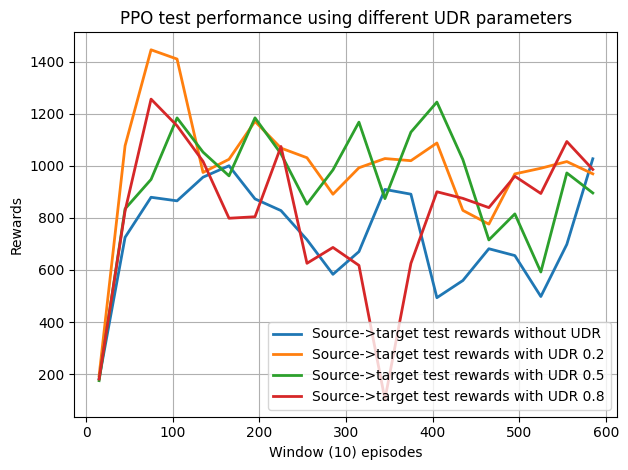

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def get_rewards (filename, window_size: int = 30):
    with open(filename, 'r') as f:
        lines = f.readlines()
        data = [float(line.strip()) for line in lines]

        means = []
        positions = []
        for i in range(0, len(data), window_size):
            window = data[i:i+window_size]
            mean_value = np.mean(window)
            means.append(mean_value)
            positions.append(i + window_size//2)
        
        return means, positions
    
path_test_resources = './trained-models/udr/seed-10'

s_t_test_rewards, st_positions = get_rewards(f'{path_test_resources}/no-udr/test_rewards_CustomHopper-target-v0.txt')
plt.plot(st_positions[:20], s_t_test_rewards[:20], label=f'Source->target test rewards without UDR', linewidth=2)

deltas = [0.2, 0.5, 0.8]
for delta in deltas:
    r, p = get_rewards(f"{path_test_resources}/{delta}/test_rewards_CustomHopper-target-v0.txt")
    plt.plot(p[:20], r[:20], label=f'Source->target test rewards with UDR {delta}', linewidth=2)


plt.ylabel("Rewards")
plt.xlabel(f"Window ({10}) episodes")
plt.title("PPO test performance using different UDR parameters")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

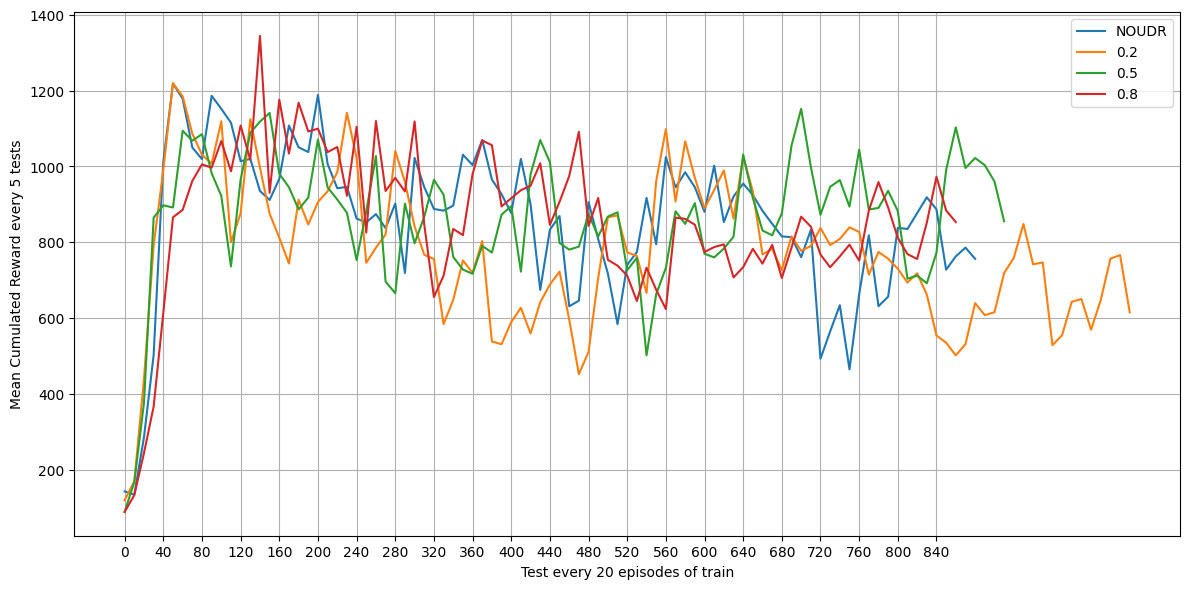

In [ ]:
import matplotlib.pyplot as plt

labels = ['NOUDR', '0.2', '0.5','0.8']
def plot_group_means_no_window(file_list):
    assert len(file_list) % 3 == 0, "Il numero di file deve essere un multiplo di 3"

    plt.figure(figsize=(12, 6))  # Un unico grafico per tutti i gruppi

    for i in range(0, len(file_list), 3):
        group = file_list[i:i+3]
        all_values = []

        for filename in group:
            with open(filename, 'r') as f:
                lines = f.readlines()
                # Salta la prima riga (presumibilmente intestazione)
                values = [float(line.strip()) for line in lines[1:]]
                all_values.append(values)

        # Taglia tutti alla lunghezza minima comune
        min_len = min(len(v) for v in all_values)
        all_values = [v[:min_len] for v in all_values]

        # Calcola la media per episodio
        pointwise_mean = [
            sum(vals) / len(vals)
            for vals in zip(*all_values)
        ]

        # Raggruppa ogni 50 valori e calcola la media per blocco
        block_size = 10
        num_blocks = len(pointwise_mean) // block_size
        pointwise_mean_blocked = [
        sum(pointwise_mean[i*block_size:(i+1)*block_size]) / block_size
        for i in range(num_blocks)]

        # Plot
        plt.plot(pointwise_mean_blocked, markersize=3, label=labels[i//3])
    # Numero di blocchi plottati
    # Numero di blocchi plottati
    num_blocks = len(pointwise_mean_blocked)

    tick_interval = 4  # ogni 4 blocchi * 5 episodi = ogni 20 episodi

    xticks_positions = list(range(0, num_blocks, tick_interval))
    xticks_labels = [str(i * block_size) for i in xticks_positions]

    plt.xticks(xticks_positions, xticks_labels)

    plt.xlabel('Test every 20 episodes of train')
    plt.ylabel('Mean Cumulated Reward every 5 tests')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

file_list = [
    'trained-models/udr/seed-10/no-udr/test_rewards_CustomHopper-target-v0.txt',
    'trained-models/udr/seed-10/0.2/test_rewards_CustomHopper-target-v0.txt',
    'trained-models/udr/seed-10/0.5/test_rewards_CustomHopper-target-v0.txt',
    'trained-models/udr/seed-10/0.8/test_rewards_CustomHopper-target-v0.txt',
    
    'trained-models/udr/seed-20/no-udr/test_rewards_CustomHopper-target-v0.txt',
    'trained-models/udr/seed-20/0.2/test_rewards_CustomHopper-target-v0.txt',
    'trained-models/udr/seed-20/0.5/test_rewards_CustomHopper-target-v0.txt',
    'trained-models/udr/seed-20/0.8/test_rewards_CustomHopper-target-v0.txt',

    
    'trained-models/udr/seed-40/no-udr/test_rewards_CustomHopper-target-v0.txt',
    'trained-models/udr/seed-40/0.2/test_rewards_CustomHopper-target-v0.txt',
    'trained-models/udr/seed-40/0.5/test_rewards_CustomHopper-target-v0.txt',
    'trained-models/udr/seed-40/0.8/test_rewards_CustomHopper-target-v0.txt'
]

plot_group_means_no_window(file_list)